# Setup

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate

import os
import time

from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation

import seaborn as sns
import json

In [2]:
# Enable interactive plot
%matplotlib notebook

In [3]:
from cosmo_bbh_tools import cosmo_bbh_tools as cbt

In [4]:
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
H0 = cosmo.H(0)
t0 = 1.0/H0
t0_Myr = t0.decompose().to(u.Myr)
T_HUBBLE_MYR = t0_Myr.value
print(T_HUBBLE_MYR)

14105.485021361645


In [5]:
def get_index(n, met):
    assert met < len(metallicities), f"metallicity index cannot exceed {len(metallicities)-1}"
    return n*len(metallicities) + met

In [6]:
PathData =     os.environ['WORK'] + '/cosmo_bh_grid/'

In [7]:
n_systems_all = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
n_systems = n_systems_all[:]
print(n_systems)

zminn = 0.000100 # COMPAS MIN
zmaxx = 0.030000 # COMPAS MAX
Z_MIN_LOG = np.log10(zminn)
Z_MAX_LOG = np.log10(zmaxx)

metallicities = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 10)
print(metallicities)

[50.0, 500.0, 5000.0, 50000.0, 500000.0, 5000000.0]
[0.0001     0.00018847 0.0003552  0.00066943 0.00126166 0.00237782
 0.0044814  0.00844598 0.01591789 0.03      ]


In [8]:
Z_ALL, M1_ZAMS_ALL, M2_ZAMS_ALL, M1_CO_ALL, M2_CO_ALL, \
                SMA_CO_ALL, ECC_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, DELAY_TIMES_ALL  = cbt.load_data(n_systems, metallicities, PathData)

loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_1.00e-04_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_1.88e-04_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_3.55e-04_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_6.69e-04_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_1.26e-03_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_2.38e-03_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_4.48e-03_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_8.45e-03_combined.h5
No DCOs were found
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+01/met_1.59e-02_combin

In [9]:
sfm = cbt.get_sfm(n_systems, metallicities, M1_ZAMS_ALL, M2_ZAMS_ALL)
print(sfm)

Star Forming Mass in 5.00e+01 stars: 4.44e+04 M_sol 

Star Forming Mass in 5.00e+02 stars: 4.77e+05 M_sol 

Star Forming Mass in 5.00e+03 stars: 5.36e+06 M_sol 

Star Forming Mass in 5.00e+04 stars: 5.61e+07 M_sol 

Star Forming Mass in 5.00e+05 stars: 5.60e+08 M_sol 

Star Forming Mass in 5.00e+06 stars: 5.61e+09 M_sol 

[4.44005395e+04 4.76630636e+05 5.36331766e+06 5.60662484e+07
 5.60322096e+08 5.61347478e+09]


In [10]:
# Isolate BBHs
M1_BBH_ALL = cbt.mask_type(M1_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
M2_BBH_ALL = cbt.mask_type(M2_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
SMA_BBH_ALL = cbt.mask_type(SMA_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
ECC_BBH_ALL = cbt.mask_type(ECC_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
TYPE1_BBH_ALL = cbt.mask_type(TYPE1_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
TYPE2_BBH_ALL = cbt.mask_type(TYPE2_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
DELAY_TIMES_BBH_ALL  = cbt.mask_type(DELAY_TIMES_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')

In [11]:
len(M1_BBH_ALL)

60

In [14]:
M1_BBH_METS = cbt.flatten_list_by_met(sfm, metallicities, M1_BBH_ALL)
M2_BBH_METS = cbt.flatten_list_by_met(sfm, metallicities, M2_BBH_ALL)
DELAY_TIMES_METS = cbt.flatten_list_by_met(sfm, metallicities, DELAY_TIMES_BBH_ALL)

# Save raw data

In [13]:
output_dir = "raw_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [48]:
for i in range(len(M1_BBH_ALL)):
    M1_BBH_ALL[i] = list(M1_BBH_ALL[i])

In [50]:
for i in range(len(M2_BBH_ALL)):
    M2_BBH_ALL[i] = list(M2_BBH_ALL[i])

In [51]:
for i in range(len(DELAY_TIMES_BBH_ALL)):
    DELAY_TIMES_BBH_ALL[i] = list(DELAY_TIMES_BBH_ALL[i])

In [29]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


In [52]:
for data in [M1_BBH_ALL, M2_BBH_ALL, DELAY_TIMES_BBH_ALL]:
    fname = retrieve_name(data)[0]
    with open(f"{output_dir}/{fname}",'w') as myfile:
        json.dump(data, myfile)

## save M1, M2, Delay times by metallicity

In [80]:
output_dir = "bbh_by_met"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [81]:
fname = f"M1_BBH_METS"
with open(f"{output_dir}/{fname}",'w') as myfile:
    json.dump(M1_BBH_METS,myfile)
    
fname = f"M2_BBH_METS"
with open(f"{output_dir}/{fname}",'w') as myfile:
    json.dump(M2_BBH_METS,myfile)
    
fname = f"DELAY_TIMES_BBH_METS"
with open(f"{output_dir}/{fname}",'w') as myfile:
    json.dump(DELAY_TIMES_METS,myfile)

# Getting BBHs from SFM, Metallicity

In [78]:
with open(f"{output_dir}/{fname}",'r') as infile:
    newList = json.load(infile)

In [12]:
# set some arbitrary values of sfm, Z
SFM = 3.7e6
MET = 0.000259

In [13]:
met_sfm_to_n_bbh = cbt.interpolate_n_bbh(sfm, metallicities, M1_BBH_ALL)
n_bbh = met_sfm_to_n_bbh(MET, SFM)
print(n_bbh)

[60.06792384]


In [15]:
start = time.time()

M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.sample_bbh_from_sfm_met(SFM, MET, sfm, metallicities, met_sfm_to_n_bbh, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS, M1_BBH_ALL)

end = time.time()

print(f'Computation completed in {end-start:.2f} s')

Computation completed in 0.16 s


In [16]:
len(M2_SAMPLED)

57

# Mass Distribution Animation

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets

class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=None, mini=0, maxi=100, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        FuncAnimation.__init__(self,self.fig, self.update, frames=self.play(), 
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
    def backward(self, event=None):
        self.forwards = False
        self.start()
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
        self.func(self.i)
        self.slider.set_val(self.i)
        self.fig.canvas.draw_idle()

    def setup(self, pos):
        playerax = self.fig.add_axes([pos[0],pos[1], 0.64, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        sliderax = divider.append_axes("right", size="500%", pad=0.07)
        self.button_oneback = matplotlib.widgets.Button(playerax, label='$\u29CF$')
        self.button_back = matplotlib.widgets.Button(bax, label='$\u25C0$')
        self.button_stop = matplotlib.widgets.Button(sax, label='$\u25A0$')
        self.button_forward = matplotlib.widgets.Button(fax, label='$\u25B6$')
        self.button_oneforward = matplotlib.widgets.Button(ofax, label='$\u29D0$')
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)
        self.slider = matplotlib.widgets.Slider(sliderax, '', 
                                                self.min, self.max, valinit=self.i)
        self.slider.on_changed(self.set_pos)

    def set_pos(self,i):
        self.i = int(self.slider.val)
        self.func(self.i)

    def update(self,i):
        self.slider.set_val(i)


<IPython.core.display.Javascript object>


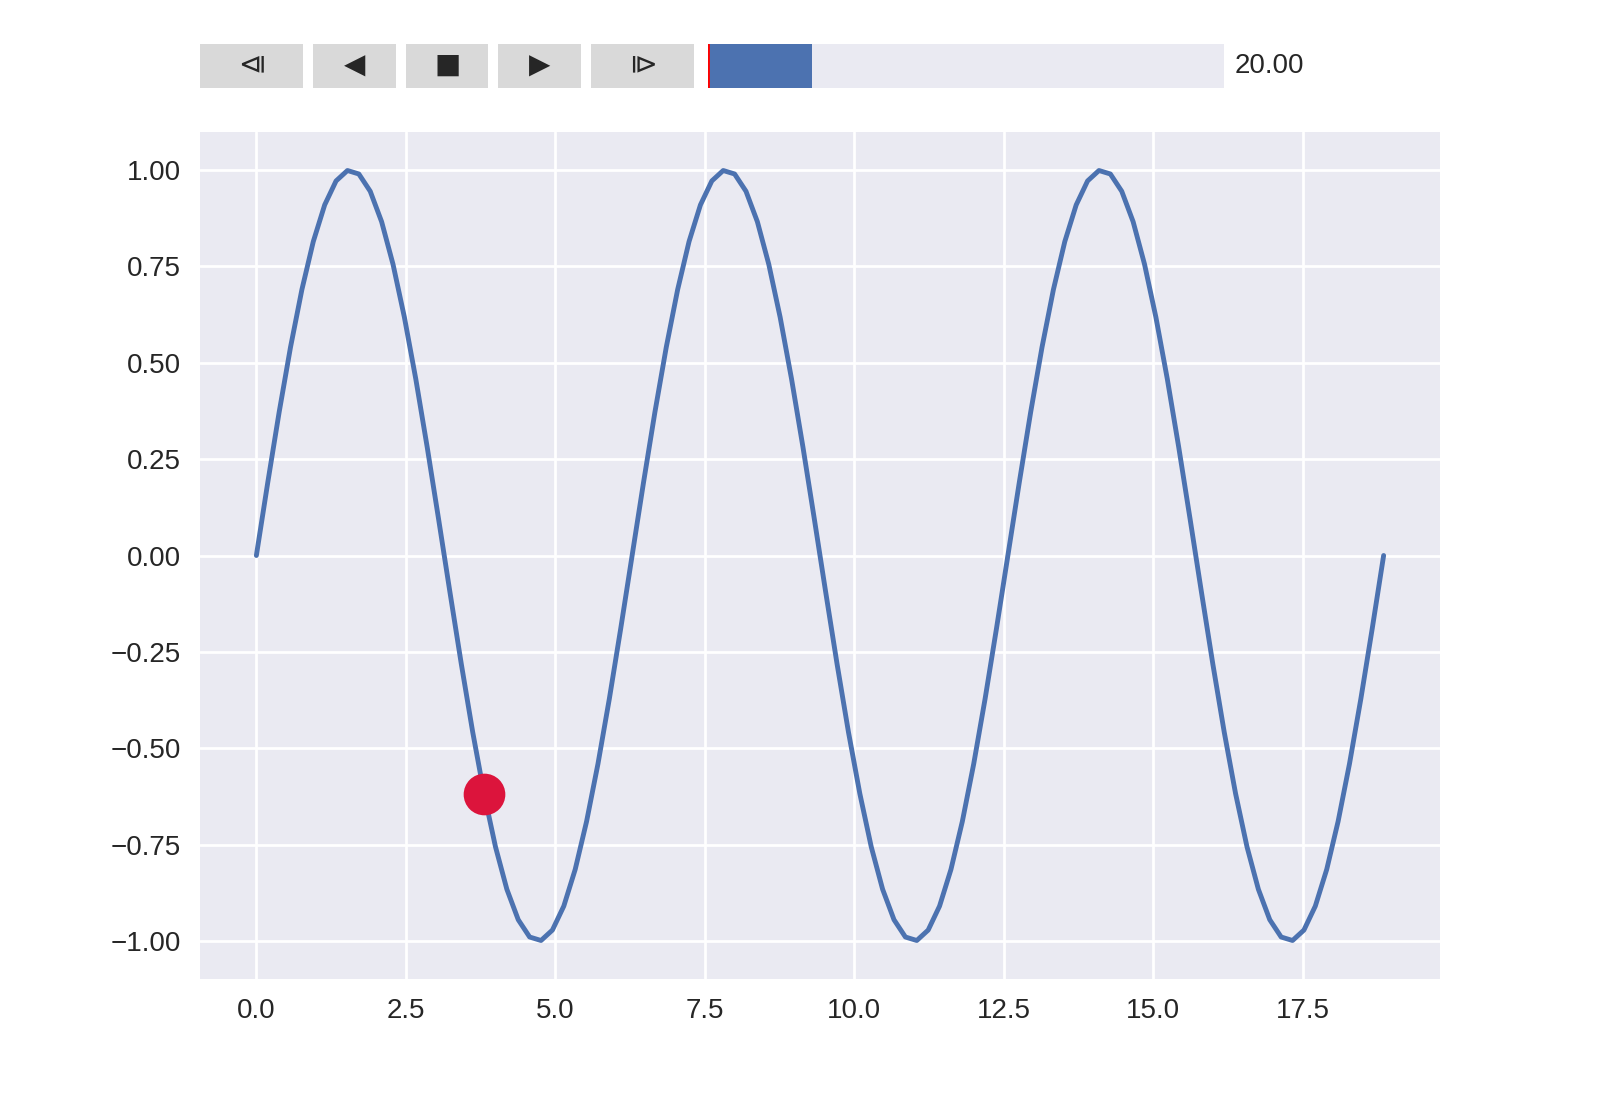

In [74]:
fig, ax = plt.subplots()
x = np.linspace(0,6*np.pi, num=100)
y = np.sin(x)

ax.plot(x,y)
point, = ax.plot([],[], marker="o", color="crimson", ms=15)

def update(i):
    point.set_data(x[i],y[i])

ani = Player(fig, update, maxi=len(y)-1)

In [53]:
n_met = 100
met_plot_range = np.logspace(Z_MIN_LOG, Z_MAX_LOG, n_met)

In [56]:
SFM = 8.7e6
m1_samples = []

for i in range(len(met_plot_range)):
    MET = met_plot_range[i]
    M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.sample_bbh_from_sfm_met(SFM, MET, sfm, metallicities, met_sfm_to_n_bbh, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS, M1_BBH_ALL)
    m1_samples.append(M1_SAMPLED)

<IPython.core.display.Javascript object>


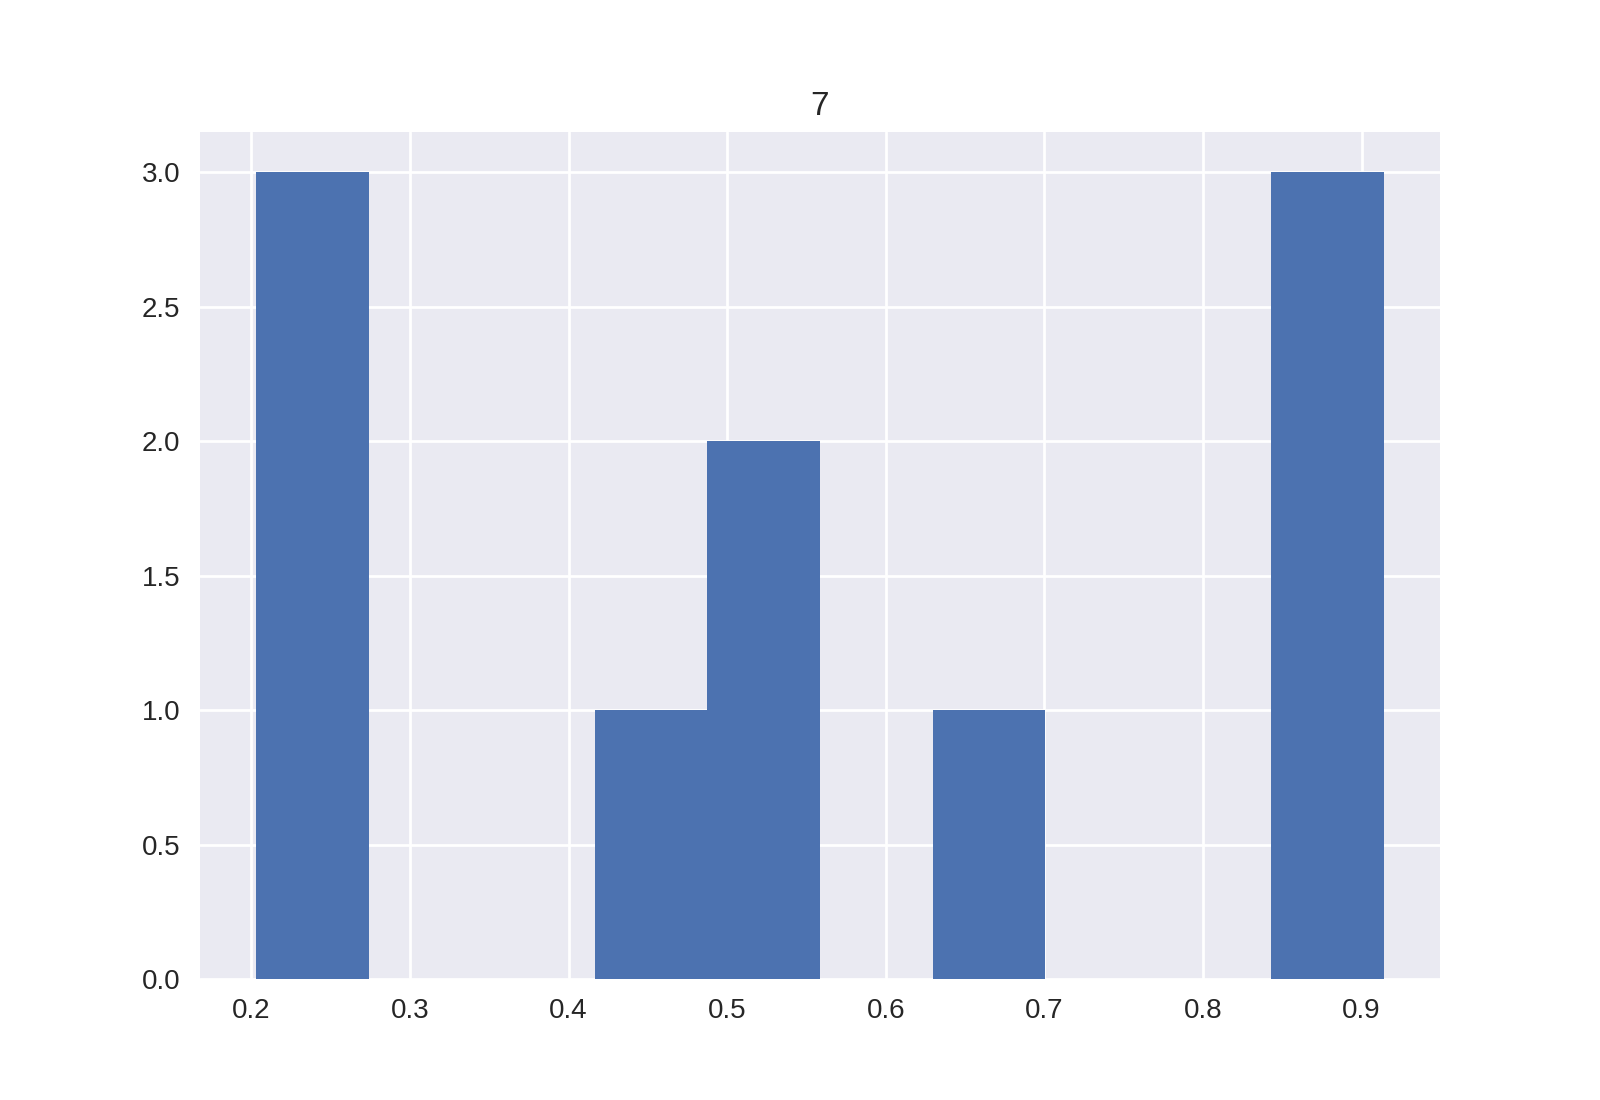

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

n = 100
number_of_frames = 10
data = np.random.rand(n, number_of_frames)

def update_hist(num, data):
    plt.cla()
    plt.hist(data[num])
    plt.title(f'{num}')

fig = plt.figure()
hist = plt.hist(data[0])

animation = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(data, ) )
plt.show()

# (Working out the code)

In [11]:
# set some arbitrary values of sfm, Z
SFM = 3.7e6
MET = 0.000259

In [12]:
met_sfm_to_n_bbh = cbt.interpolate_n_bbh(sfm, metallicities, M1_BBH_ALL)

In [13]:
n_bbh = met_sfm_to_n_bbh(MET, SFM)
print(n_bbh)

[60.06792384]


In [14]:
weights = cbt.met_to_met_weights(MET, metallicities)
print(weights)

[1.73504530e-01 2.85736373e-01 2.85967190e-01 1.73925338e-01
 6.42843827e-02 1.44392312e-02 1.97096372e-03 1.63496765e-04
 8.24205799e-06 2.52498114e-07]


In [15]:
n_met_samples = (weights*n_bbh).astype(int)
print(n_met_samples)
print(np.sum(n_met_samples))

[10 17 17 10  3  0  0  0  0  0]
57


In [16]:
M1_BBH_METS = cbt.flatten_list_by_met(sfm, metallicities, M1_BBH_ALL)
M2_BBH_METS = cbt.flatten_list_by_met(sfm, metallicities, M2_BBH_ALL)
DELAY_TIMES_METS = cbt.flatten_list_by_met(sfm, metallicities, DELAY_TIMES_BBH_ALL)

In [17]:
M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.draw_bbh_from_met(n_met_samples, metallicities, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS)

# Star Forming Mass-Z-N_BBH Relation

In [182]:
N_BBH = np.zeros(len(M1_BBH_ALL))
for i in range(len(N_BBH)):
    N_BBH[i] = len(M1_BBH_ALL[i])

In [183]:
N_BBH_GRID = np.reshape(N_BBH, (len(sfm), len(metallicities)))
np.shape(N_BBH_GRID)

(6, 10)

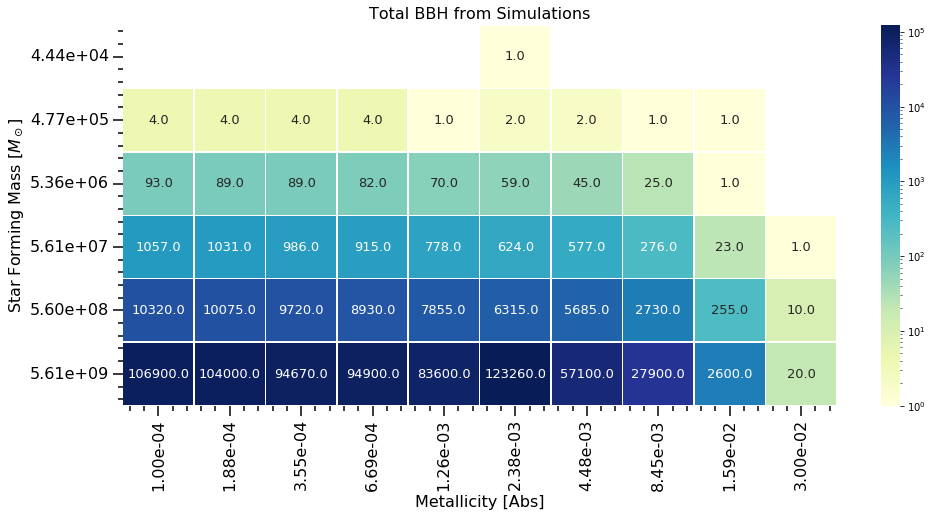

In [190]:
# original grid
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(N_BBH_GRID, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=metallicities, yticklabels=sfm, \
                annot=N_BBH_GRID, annot_kws={'fontsize':13}, fmt='.1f')

cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Total BBH from Simulations", fontsize=16)

plt.show()

In [195]:
met_sfm_to_n_bbh = interpolate.interp2d(metallicities, sfm, N_BBH_GRID)

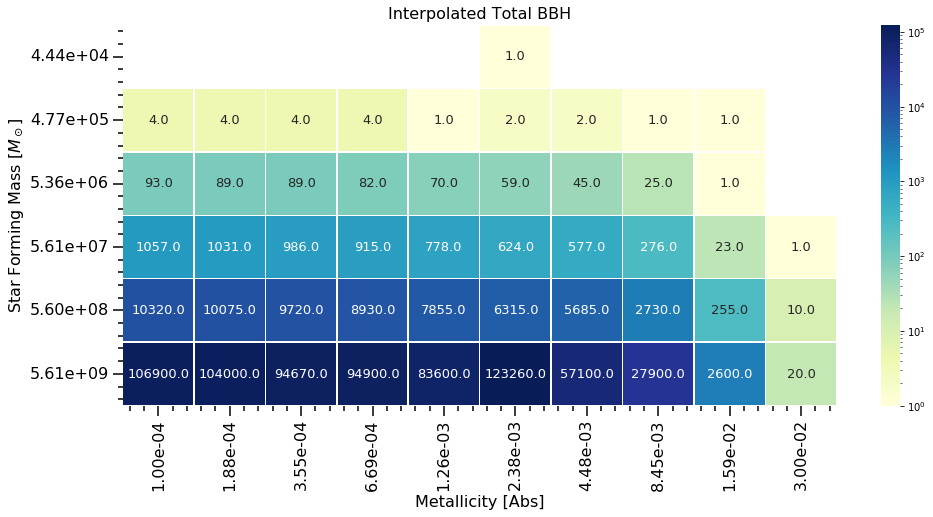

In [196]:
# original grid (interpolated)
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(met_sfm_to_n_bbh(metallicities, sfm), cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=metallicities, yticklabels=sfm, \
                annot=met_sfm_to_n_bbh(metallicities, sfm), annot_kws={'fontsize':13}, fmt='.1f')

cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Interpolated Total BBH", fontsize=16)

plt.show()

That matches the true values exactly, now let's try some new values.

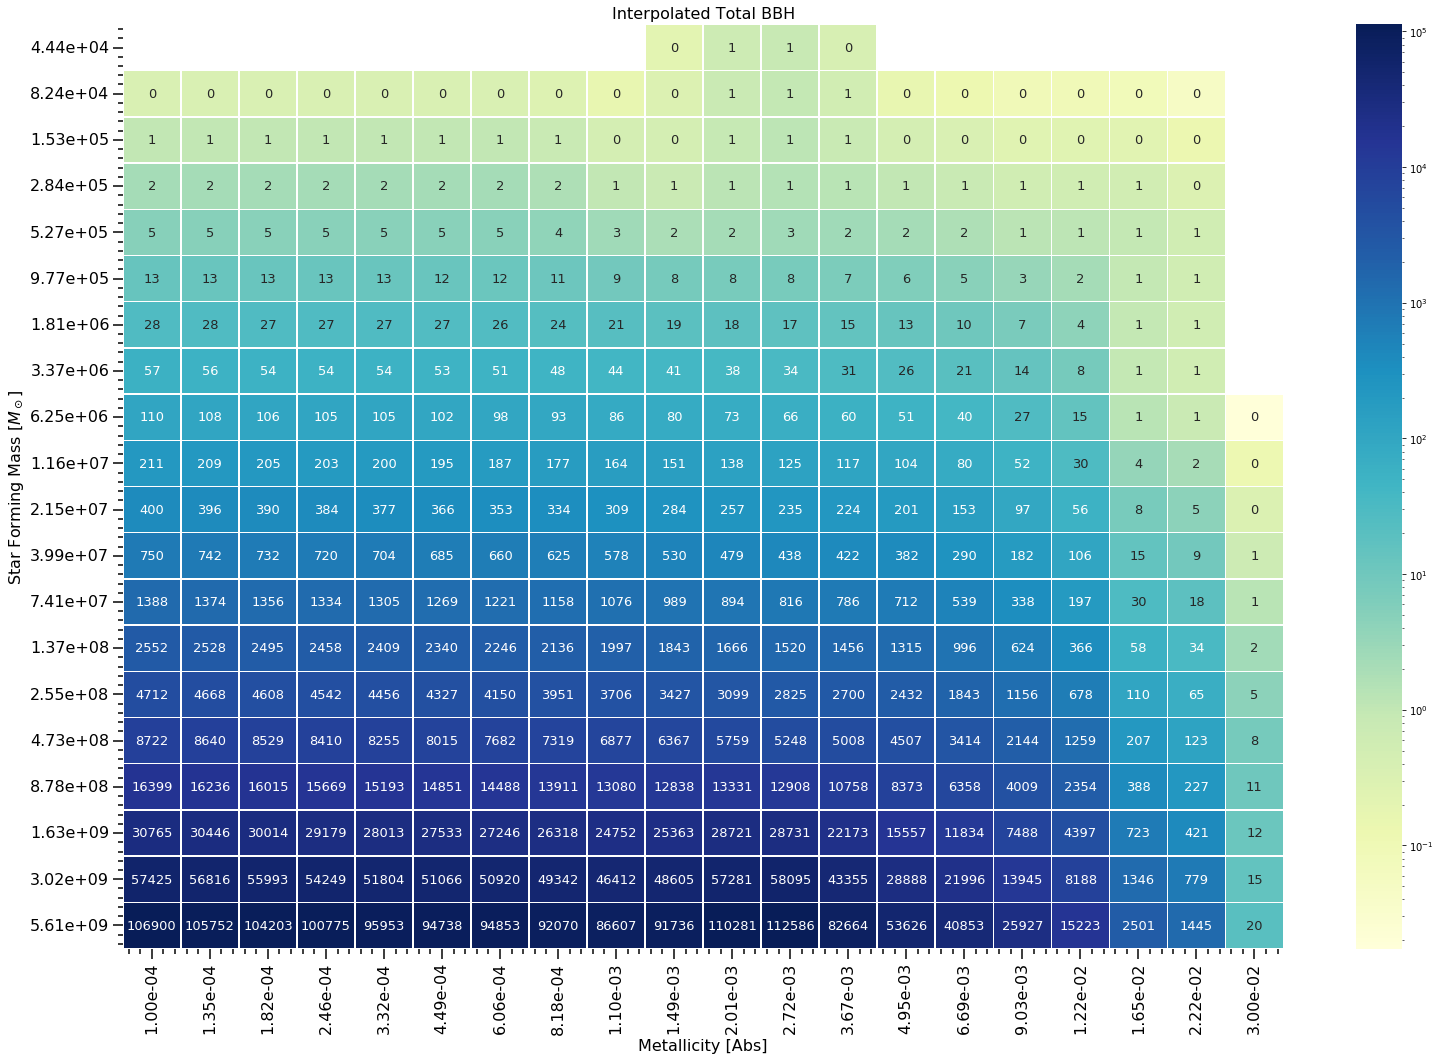

In [199]:
m = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 20)
s = np.logspace(np.log10(sfm[0]), np.log10(sfm[-1]), 20)

f, ax= plt.subplots(1, 1,  figsize=(26,17)) 

ax = sns.heatmap(met_sfm_to_n_bbh(m, s), cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=m, yticklabels=s, \
                annot=met_sfm_to_n_bbh(m,s), annot_kws={'fontsize':13}, fmt='.0f')

cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Interpolated Total BBH", fontsize=16)

plt.show()

The interpolation is fine within the bounds of the original simulations. Outside, it starts leveling out. This is because the 2d extrapolation is 'nearest neighbor', whereas the 1d extrapolation is proper extrapolation. See https://github.com/scipy/scipy/issues/8099 for more info.

For now, we will assume that the SFM and Metallicities will all be within the simulated range. If there are any values outside, we will first have to use interp1d to extend the data range, and then use interp2d.

Now that we have a number of BBHs, how do we actually draw them?
One way would be to reassign the metallicities across all BBHs so that they form a ~continuous distribution of metallicities. See Fig. 10 and Eq. (48) https://arxiv.org/pdf/2109.10352.pdf to see how we can assign a gaussian distribution centered around each Z value.

Then, given a metallicity value, we can find the relative contribution from each Z gaussian, and draw the appropriate # of BBHs from that Z simulation.

# Metallicity value to set of BBHs

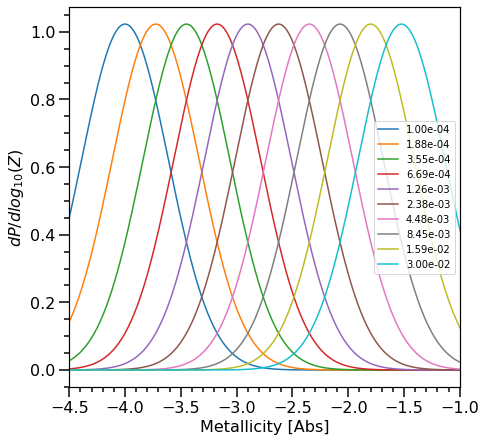

In [226]:
f, ax= plt.subplots(1, 1,  figsize=(7,7)) 

x = np.linspace(Z_MIN_LOG-2, Z_MAX_LOG+2, 500)
SIGMA_Z = 0.39

for met in np.log10(metallicities):
    mu = met
    ax.plot(x, stats.norm.pdf(x, mu, SIGMA_Z), label=f'{10**met:.2e}')
    
cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='$dP/dlog_{10}(Z)$', fontsize=16)
plt.legend()
plt.xlim(-4.5, -1.0)
plt.show()
    

In [230]:
def met_to_met_weights(met, metallicities):
    SIGMA_Z = 0.39
    log_metallicities = np.log10(metallicities)
    log_met = np.log10(met)
    weights = np.zeros(len(log_metallicities))
    
    for i in range(len(log_metallicities)):
        mu = log_metallicities[i]
        weights[i] = stats.norm.pdf(log_met, mu, SIGMA_Z)
    weights = weights/np.sum(weights)
    return weights    

In [233]:
met = 0.00272
weights = met_to_met_weights(met, metallicities)
print(weights)

[0.000325   0.00339736 0.02158214 0.08331878 0.19547318 0.27869389
 0.24147028 0.12714401 0.04068404 0.00791131]
